In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [6]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    # Вихідний шар
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.layer_3(x, activation=1)

    return x

In [7]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    y_pred_labels = tf.argmax(y_pred, axis=1, output_type=tf.int64)

    y_true = tf.cast(y_true, tf.int64)

    correct_predictions = tf.equal(y_pred_labels, y_true)

    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [8]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y, learning_rate):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

  # Отримаємо список оптимізованих параметрів
  parameter = neural_net.trainable_variables
  # Обчислимо за ними значення градієнта
  gradients = g.gradient(loss, parameter)

  # Модифікуємо параметри
  optimizer.apply_gradients(zip(gradients, parameter))

  return loss

In [9]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y, learning_rate=learning_rate)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)

        current_loss = cross_entropy(pred, batch_y)
        current_accuracy = accuracy(pred, batch_y)
        accuracy_history.append(current_accuracy)
        loss_history.append(current_loss)
        print(f"Step {step}, Loss: {current_loss}, Accuracy: {current_accuracy}")

Step 100, Loss: 331.0301513671875, Accuracy: 0.69140625
Step 200, Loss: 210.1138458251953, Accuracy: 0.78125
Step 300, Loss: 166.1688232421875, Accuracy: 0.80859375
Step 400, Loss: 203.36239624023438, Accuracy: 0.8203125
Step 500, Loss: 113.78910064697266, Accuracy: 0.85546875
Step 600, Loss: 127.26104736328125, Accuracy: 0.82421875
Step 700, Loss: 113.46231079101562, Accuracy: 0.87109375
Step 800, Loss: 92.38932800292969, Accuracy: 0.8984375
Step 900, Loss: 132.98509216308594, Accuracy: 0.8671875
Step 1000, Loss: 91.81428527832031, Accuracy: 0.89453125
Step 1100, Loss: 112.22018432617188, Accuracy: 0.8828125
Step 1200, Loss: 78.77428436279297, Accuracy: 0.9453125
Step 1300, Loss: 92.86320495605469, Accuracy: 0.89453125
Step 1400, Loss: 88.24874877929688, Accuracy: 0.91015625
Step 1500, Loss: 78.25350952148438, Accuracy: 0.89453125
Step 1600, Loss: 96.78205108642578, Accuracy: 0.890625
Step 1700, Loss: 115.73760986328125, Accuracy: 0.8828125
Step 1800, Loss: 87.11070251464844, Accuracy

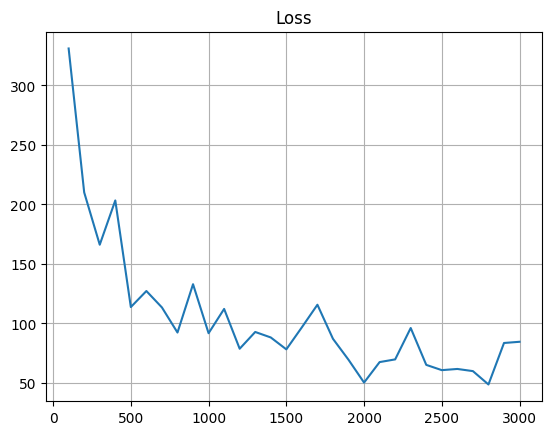

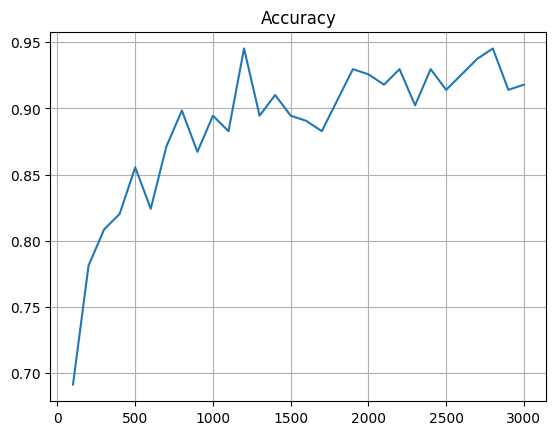

In [10]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt
step_history = [step + 100 for step in range(training_steps) if step % display_step == 0 ]

# Виведіть графік функції втрат
plt.plot(step_history, loss_history)
plt.title("Loss")
plt.grid()
plt.show()

# Виведіть графік точності
plt.plot(step_history, accuracy_history)
plt.title("Accuracy")
plt.grid()
plt.show()

In [11]:
# Обчисліть точність навченої нейромережі
train_pred = neural_net(x_train)
train_accuracy = accuracy(train_pred, y_train)
print(f'Train accuracy = {train_accuracy.numpy()}')
# Тестування моделі на тестових даних
test_pred = neural_net(x_test)
test_accuracy = accuracy(test_pred, y_test)
print(f'Test accuracy = {test_accuracy.numpy()}')

Train accuracy = 0.9233333468437195
Test accuracy = 0.9057999849319458


In [25]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

testing_select = 10
test_pred_10 = neural_net(x_test[:testing_select])
test_acc_10 = accuracy(test_pred_10, y_test[:testing_select])
print(f"Select {testing_select} images, accuracy = {test_acc_10.numpy():.2}")

img_selected = 5
random_img_idx = np.random.randint(0, x_test.shape[0], size=img_selected)
pred = neural_net(x_test[random_img_idx])
acc = accuracy(pred, y_test[random_img_idx]).numpy()

print(f"selected imnage idx: {random_img_idx}")
print("test_values:", y_test[random_img_idx])
pred = np.argmax(pred, axis=1)
print("pred_values:", pred)
print(f"accuraccy : {acc:.2}")

Select 10 images, accuracy = 0.9
selected imnage idx: [6860 5363 4390 7026 4237]
test_values: [5 7 8 3 9]
pred_values: [5 7 8 3 9]
accuraccy : 1.0


In [26]:
test_pred = neural_net(x_test)
test_pred = np.argmax(test_pred, axis=1)
confusion_matrix(y_test, test_pred)

array([[ 923,    0,   10,    1,    1,   17,   16,    4,    6,    2],
       [   0, 1100,    7,    4,    0,    2,    6,    2,   14,    0],
       [  11,    8,  925,   18,   11,    5,    6,   15,   29,    4],
       [   4,    3,   30,  894,    3,   39,    3,    8,   20,    6],
       [   1,    0,    9,    3,  867,    2,   23,    8,   11,   58],
       [  13,    2,    4,   33,    7,  790,   12,    6,   16,    9],
       [   6,    2,   10,    2,   12,   11,  908,    0,    7,    0],
       [   1,    7,   27,    8,   12,    5,    0,  928,    5,   35],
       [   5,    2,   18,   19,    6,   40,   13,   12,  843,   16],
       [   5,    5,    7,    6,   43,   17,    3,   28,   15,  880]],
      dtype=int64)

In [27]:
from sklearn.metrics import classification_report
report = classification_report(y_test, test_pred, target_names=[str(i) for i in range(num_classes)])
print(report)

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       980
           1       0.97      0.97      0.97      1135
           2       0.88      0.90      0.89      1032
           3       0.90      0.89      0.89      1010
           4       0.90      0.88      0.89       982
           5       0.85      0.89      0.87       892
           6       0.92      0.95      0.93       958
           7       0.92      0.90      0.91      1028
           8       0.87      0.87      0.87       974
           9       0.87      0.87      0.87      1009

    accuracy                           0.91     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.91      0.91      0.91     10000

